In [44]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from einops import rearrange,reduce,repeat
from tqdm import trange
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print(device)

cuda


# MLP 

In [9]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, 1024), nn.ReLU()]
        self.model += [nn.Dropout(0.5)]
        self.model += [nn.Linear(1024, 256), nn.ReLU()]
        self.model += [nn.Linear(256, 128), nn.ReLU()]
        #for i in range(num_layers-2):
        #    self.model += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1, 2)

In [10]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        #out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, (h_t, c_t)
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0
    



In [11]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [12]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        p_in_raw = scene['p_in']
        p_out_raw = scene['p_out'][pred_id]
        v_in_raw = scene['v_in']
        v_out_raw = scene['v_out'][pred_id]
        lane_scene = scene['lane']
        
        # Normalization
        min_vecs = np.min(lane_scene, axis = 0)
        max_vecs = np.max(lane_scene, axis = 0)
        
        # Normalize by vectors
        p_in_normalized = (p_in_raw - min_vecs)/(max_vecs - min_vecs)
        p_out_normalized = (p_out_raw - min_vecs)/(max_vecs - min_vecs)
        v_in_norm = np.linalg.norm(v_in_raw, axis=1, keepdims=True)
        v_in_norm = np.where(v_in_norm == 0.0, 1.0, v_in_norm)
        v_in_normalized = v_in_raw / v_in_norm
        # v_out_normalized = v_out_raw / np.linalg.norm(v_out_raw, axis=1, keepdims=True)
        inp = np.concatenate((p_in_normalized,v_in_normalized),axis=1)
        
        # Convert to float torch tensor
        return torch.from_numpy(inp).float(), torch.from_numpy(p_out_normalized).float()

In [13]:
class RNNdataset(torch.utils.data.Dataset):
    def __init__(self, 
                 data_path,
                 sample_indices):
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)
    
    def __getitem__(self,idx):
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        mask = np.where(scene['car_mask'] == 1)[0]
    
        
        # input: p_in & v_in; output: p_out
        p_in_raw = scene['p_in']
        p_out_raw = scene['p_out'][pred_id]
        v_in_raw = scene['v_in']
        
        lane_scene = scene['lane']
        
        # Normalization
        min_vecs = np.min(lane_scene, axis = 0)
        max_vecs = np.max(lane_scene, axis = 0)
        
        # Normalize by vectors
        p_in_norm = (p_in_raw - min_vecs)/(max_vecs - min_vecs)
        
        v_in_norm = np.linalg.norm(v_in_raw, axis=1, keepdims=True)
        v_in_norm = np.where(v_in_norm == 0.0, 1.0, v_in_norm)
        v_in_norm = v_in_raw / v_in_norm
        # v_out_normalized = v_out_raw / np.linalg.norm(v_out_raw, axis=1, keepdims=True)
        p_track = p_in_norm[mask].reshape(-1,19*2)
        v_track = v_in_norm[mask].reshape(-1,19*2)
        
        p_agent = p_in_norm[pred_id].reshape(1,-1)
        v_agent = v_in_norm[pred_id].reshape(1,-1)
        new_mask = []
        p_result = []
        v_result = []
        if (len(mask) > 10):
            
            dist = ((p_track - p_agent)**2).sum(axis=-1)
            #print('dist is ',dist.shape)
            new_mask = np.argpartition(dist,10)[:10]
            
            p_result = p_track[new_mask,:]
            v_result = v_track[new_mask,:]
        else:
            p_result = np.zeros((10,38))
            v_result = np.zeros((10,38))
            k = p_track.shape[0]
            #print('slice',k)
            p_result[:k] = p_track
            v_result[:k] = v_track
        
        #print('shape is',p_agent.shape,v_agent.shape,p_result.shape,v_result.shape)
        inp = np.vstack((p_agent,v_agent,p_result,v_result))
        #print('inp shape is',inp.shape)


        p_out_normalized = (p_out_raw - min_vecs)/(max_vecs - min_vecs)
        p_out_norm = rearrange(p_out_normalized, 'a b -> (a b)')
        # Convert to float torch tensor
        return torch.from_numpy(inp).float(), torch.from_numpy(p_out_norm).float()



In [14]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [15]:
# Grid/Random Search

In [16]:
batch_size = 1024
in_dim = 19*2
out_dim = 30*2
hidden_dim = 128
num_layers = 3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [17]:
train_path = "./train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

train_set = RNNdataset(train_path, train_indices)
valid_set = RNNdataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=8)

# Model, Loss Function and Optimizer

In [18]:
# RNN, LSTM, 1dCNN, Transformer
# model = MLPNet(in_dim = in_dim, 
#                out_dim = out_dim,
#                hidden_dim = hidden_dim, 
#                num_layers = num_layers).to(device) # move model to gpu 

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 
# Instantiate the model with hyperparameters
model = MyLSTM(input_size=in_dim, output_size=out_dim, hidden_dim=70, n_layers=2).to(device)   #maximum number of hidden size is 120



optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()
writer = SummaryWriter()


# Training

In [19]:
def train_epoch(train_loader, model, optimizer, loss_function):
    model.train()
    train_mse = []
    for inp, tgt in train_loader:
        inp = inp.to(device)
        tgt = tgt.to(device)
       
        
        pred,_ = model(inp)
        #print(pred.shape,tgt.shape)
        pred = pred[:,-1, :].squeeze(1)
        loss = loss_function(pred, tgt)
        train_mse.append(loss.item()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    model.eval()
    valid_mse = []
    preds = []
    trues = []
    with torch.no_grad():
        for inp, tgt in valid_loader:
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            pred,_ = model(inp)
            #print(tgt.shape,pred.shape)
            pred = pred[:,-1, :].squeeze(1)
            loss = loss_function(pred, tgt)
            preds.append(pred.cpu().data.numpy())
            trues.append(tgt.cpu().data.numpy())
            valid_mse.append(loss.item())
            
        preds = np.concatenate(preds, axis = 0)  
        trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse, preds, trues


In [20]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

In [21]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8
print(device)
for i in trange(num_epoch):
    start = time.time()

    # model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))

    # model.eval()
    val_rmse, val_preds, val_trues = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        print('Get best model')
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break       

    # Learning Rate Decay        
    scheduler.step()
     # Log scalars to TensorBoard
    writer.add_scalar('Loss', train_rmse[-1], i)
    writer.add_scalar('Accuracy', valid_rmse[-1], i)
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

cuda


  0%|          | 1/1000 [00:26<7:19:15, 26.38s/it]

Get best model
Epoch 1 | T: 0.44 | Train RMSE: 0.21510 | Valid RMSE: 0.08929


  0%|          | 2/1000 [00:54<7:36:17, 27.43s/it]

Get best model
Epoch 2 | T: 0.47 | Train RMSE: 0.05810 | Valid RMSE: 0.04243


  0%|          | 3/1000 [01:25<8:05:10, 29.20s/it]

Get best model
Epoch 3 | T: 0.52 | Train RMSE: 0.03829 | Valid RMSE: 0.03474


  0%|          | 4/1000 [01:54<8:00:09, 28.93s/it]

Get best model
Epoch 4 | T: 0.48 | Train RMSE: 0.03591 | Valid RMSE: 0.03358


  0%|          | 5/1000 [02:18<7:33:02, 27.32s/it]

Epoch 5 | T: 0.41 | Train RMSE: 0.03351 | Valid RMSE: 0.03484


  1%|          | 6/1000 [02:44<7:21:17, 26.64s/it]

Get best model
Epoch 6 | T: 0.42 | Train RMSE: 0.03336 | Valid RMSE: 0.03281


  1%|          | 7/1000 [03:10<7:20:04, 26.59s/it]

Get best model
Epoch 7 | T: 0.44 | Train RMSE: 0.03269 | Valid RMSE: 0.03260


  1%|          | 8/1000 [03:35<7:12:56, 26.19s/it]

Epoch 8 | T: 0.42 | Train RMSE: 0.03212 | Valid RMSE: 0.03364


  1%|          | 9/1000 [04:00<7:05:28, 25.76s/it]

Epoch 9 | T: 0.41 | Train RMSE: 0.03190 | Valid RMSE: 0.03267


  1%|          | 10/1000 [04:26<7:04:17, 25.71s/it]

Get best model
Epoch 10 | T: 0.43 | Train RMSE: 0.03135 | Valid RMSE: 0.03218


  1%|          | 11/1000 [04:51<7:01:23, 25.56s/it]

Get best model
Epoch 11 | T: 0.42 | Train RMSE: 0.03105 | Valid RMSE: 0.03072


  1%|          | 12/1000 [05:17<7:02:13, 25.64s/it]

Epoch 12 | T: 0.43 | Train RMSE: 0.03101 | Valid RMSE: 0.03222


  1%|▏         | 13/1000 [05:41<6:54:55, 25.22s/it]

Epoch 13 | T: 0.40 | Train RMSE: 0.03091 | Valid RMSE: 0.03111


  1%|▏         | 14/1000 [06:05<6:48:26, 24.85s/it]

Epoch 14 | T: 0.40 | Train RMSE: 0.03050 | Valid RMSE: 0.03154


  2%|▏         | 15/1000 [06:30<6:49:08, 24.92s/it]

Get best model
Epoch 15 | T: 0.42 | Train RMSE: 0.03013 | Valid RMSE: 0.03058


  2%|▏         | 16/1000 [06:55<6:47:13, 24.83s/it]

Get best model
Epoch 16 | T: 0.41 | Train RMSE: 0.03004 | Valid RMSE: 0.03048


  2%|▏         | 17/1000 [07:19<6:43:10, 24.61s/it]

Get best model
Epoch 17 | T: 0.40 | Train RMSE: 0.02966 | Valid RMSE: 0.02993


  2%|▏         | 18/1000 [07:43<6:38:42, 24.36s/it]

Epoch 18 | T: 0.40 | Train RMSE: 0.03006 | Valid RMSE: 0.03006


  2%|▏         | 19/1000 [08:07<6:36:55, 24.28s/it]

Epoch 19 | T: 0.40 | Train RMSE: 0.02975 | Valid RMSE: 0.03217


  2%|▏         | 20/1000 [08:31<6:35:41, 24.23s/it]

Epoch 20 | T: 0.40 | Train RMSE: 0.02954 | Valid RMSE: 0.03017


  2%|▏         | 21/1000 [08:56<6:37:43, 24.38s/it]

Get best model
Epoch 21 | T: 0.41 | Train RMSE: 0.02942 | Valid RMSE: 0.02965


  2%|▏         | 22/1000 [09:22<6:46:12, 24.92s/it]

Epoch 22 | T: 0.44 | Train RMSE: 0.02921 | Valid RMSE: 0.03041


  2%|▏         | 23/1000 [09:47<6:48:33, 25.09s/it]

Get best model
Epoch 23 | T: 0.42 | Train RMSE: 0.02911 | Valid RMSE: 0.02957


  2%|▏         | 24/1000 [10:13<6:51:03, 25.27s/it]

Get best model
Epoch 24 | T: 0.43 | Train RMSE: 0.02903 | Valid RMSE: 0.02951


  2%|▎         | 25/1000 [10:38<6:50:02, 25.23s/it]

Epoch 25 | T: 0.42 | Train RMSE: 0.02899 | Valid RMSE: 0.02955


  3%|▎         | 26/1000 [11:07<7:07:49, 26.35s/it]

Epoch 26 | T: 0.48 | Train RMSE: 0.02886 | Valid RMSE: 0.02997


  3%|▎         | 27/1000 [11:36<7:18:25, 27.04s/it]

Epoch 27 | T: 0.48 | Train RMSE: 0.02877 | Valid RMSE: 0.02954


  3%|▎         | 28/1000 [12:02<7:14:36, 26.83s/it]

Epoch 28 | T: 0.44 | Train RMSE: 0.02865 | Valid RMSE: 0.02973


  3%|▎         | 29/1000 [12:28<7:08:44, 26.49s/it]

Epoch 29 | T: 0.43 | Train RMSE: 0.02862 | Valid RMSE: 0.02955


  3%|▎         | 30/1000 [12:52<6:58:41, 25.90s/it]

Get best model
Epoch 30 | T: 0.41 | Train RMSE: 0.02845 | Valid RMSE: 0.02944


  3%|▎         | 31/1000 [13:17<6:50:18, 25.41s/it]

Epoch 31 | T: 0.40 | Train RMSE: 0.02832 | Valid RMSE: 0.02948


  3%|▎         | 32/1000 [13:42<6:51:33, 25.51s/it]

Get best model
Epoch 32 | T: 0.43 | Train RMSE: 0.02834 | Valid RMSE: 0.02918


  3%|▎         | 33/1000 [14:07<6:48:16, 25.33s/it]

Epoch 33 | T: 0.42 | Train RMSE: 0.02823 | Valid RMSE: 0.02924


  3%|▎         | 34/1000 [14:34<6:53:35, 25.69s/it]

Get best model
Epoch 34 | T: 0.44 | Train RMSE: 0.02826 | Valid RMSE: 0.02891


  4%|▎         | 35/1000 [14:59<6:48:23, 25.39s/it]

Epoch 35 | T: 0.41 | Train RMSE: 0.02822 | Valid RMSE: 0.02898


  4%|▎         | 36/1000 [15:24<6:46:45, 25.32s/it]

Epoch 36 | T: 0.42 | Train RMSE: 0.02802 | Valid RMSE: 0.02965


  4%|▎         | 37/1000 [15:50<6:51:17, 25.63s/it]

Get best model
Epoch 37 | T: 0.44 | Train RMSE: 0.02789 | Valid RMSE: 0.02879


  4%|▍         | 38/1000 [16:13<6:37:20, 24.78s/it]

Epoch 38 | T: 0.38 | Train RMSE: 0.02786 | Valid RMSE: 0.02884


  4%|▍         | 39/1000 [16:36<6:28:50, 24.28s/it]

Epoch 39 | T: 0.38 | Train RMSE: 0.02782 | Valid RMSE: 0.02884


  4%|▍         | 40/1000 [16:59<6:22:02, 23.88s/it]

Epoch 40 | T: 0.38 | Train RMSE: 0.02776 | Valid RMSE: 0.02880


  4%|▍         | 41/1000 [17:22<6:16:56, 23.58s/it]

Epoch 41 | T: 0.38 | Train RMSE: 0.02772 | Valid RMSE: 0.02901


  4%|▍         | 42/1000 [17:45<6:13:57, 23.42s/it]

Get best model
Epoch 42 | T: 0.38 | Train RMSE: 0.02763 | Valid RMSE: 0.02870


  4%|▍         | 43/1000 [18:08<6:12:32, 23.36s/it]

Epoch 43 | T: 0.39 | Train RMSE: 0.02767 | Valid RMSE: 0.02891


  4%|▍         | 44/1000 [18:31<6:10:51, 23.28s/it]

Get best model
Epoch 44 | T: 0.38 | Train RMSE: 0.02750 | Valid RMSE: 0.02867


  4%|▍         | 45/1000 [18:54<6:10:27, 23.28s/it]

Get best model
Epoch 45 | T: 0.39 | Train RMSE: 0.02755 | Valid RMSE: 0.02866


  5%|▍         | 46/1000 [19:17<6:08:25, 23.17s/it]

Epoch 46 | T: 0.38 | Train RMSE: 0.02743 | Valid RMSE: 0.02889


  5%|▍         | 47/1000 [19:40<6:07:16, 23.12s/it]

Epoch 47 | T: 0.38 | Train RMSE: 0.02740 | Valid RMSE: 0.02884


  5%|▍         | 48/1000 [20:06<6:17:35, 23.80s/it]

Get best model
Epoch 48 | T: 0.42 | Train RMSE: 0.02738 | Valid RMSE: 0.02861


  5%|▍         | 49/1000 [20:32<6:31:08, 24.68s/it]

Epoch 49 | T: 0.45 | Train RMSE: 0.02730 | Valid RMSE: 0.02865


  5%|▌         | 50/1000 [20:56<6:25:56, 24.38s/it]

Epoch 50 | T: 0.39 | Train RMSE: 0.02724 | Valid RMSE: 0.02868


  5%|▌         | 51/1000 [21:20<6:21:17, 24.11s/it]

Epoch 51 | T: 0.39 | Train RMSE: 0.02719 | Valid RMSE: 0.02879


  5%|▌         | 52/1000 [21:43<6:17:24, 23.89s/it]

Epoch 52 | T: 0.39 | Train RMSE: 0.02720 | Valid RMSE: 0.02861


  5%|▌         | 53/1000 [22:07<6:16:27, 23.85s/it]

Get best model
Epoch 53 | T: 0.40 | Train RMSE: 0.02714 | Valid RMSE: 0.02855


  5%|▌         | 54/1000 [22:30<6:13:39, 23.70s/it]

Epoch 54 | T: 0.39 | Train RMSE: 0.02718 | Valid RMSE: 0.02883


  6%|▌         | 55/1000 [22:53<6:11:59, 23.62s/it]

Get best model
Epoch 55 | T: 0.39 | Train RMSE: 0.02707 | Valid RMSE: 0.02850


  6%|▌         | 56/1000 [23:17<6:09:56, 23.51s/it]

Epoch 56 | T: 0.39 | Train RMSE: 0.02703 | Valid RMSE: 0.02850


  6%|▌         | 57/1000 [23:40<6:07:27, 23.38s/it]

Epoch 57 | T: 0.38 | Train RMSE: 0.02699 | Valid RMSE: 0.02852


  6%|▌         | 58/1000 [24:03<6:06:56, 23.37s/it]

Epoch 58 | T: 0.39 | Train RMSE: 0.02700 | Valid RMSE: 0.02852


  6%|▌         | 59/1000 [24:26<6:03:58, 23.21s/it]

Get best model
Epoch 59 | T: 0.38 | Train RMSE: 0.02695 | Valid RMSE: 0.02840


  6%|▌         | 60/1000 [24:49<6:02:09, 23.12s/it]

Get best model
Epoch 60 | T: 0.38 | Train RMSE: 0.02690 | Valid RMSE: 0.02838


  6%|▌         | 61/1000 [25:12<6:00:58, 23.07s/it]

Epoch 61 | T: 0.38 | Train RMSE: 0.02687 | Valid RMSE: 0.02840


  6%|▌         | 62/1000 [25:35<6:00:04, 23.03s/it]

Epoch 62 | T: 0.38 | Train RMSE: 0.02683 | Valid RMSE: 0.02838


  6%|▋         | 63/1000 [25:58<5:58:56, 22.98s/it]

Get best model
Epoch 63 | T: 0.38 | Train RMSE: 0.02683 | Valid RMSE: 0.02837


  6%|▋         | 64/1000 [26:21<5:58:42, 22.99s/it]

Epoch 64 | T: 0.38 | Train RMSE: 0.02678 | Valid RMSE: 0.02844


  6%|▋         | 65/1000 [26:44<5:58:06, 22.98s/it]

Epoch 65 | T: 0.38 | Train RMSE: 0.02679 | Valid RMSE: 0.02839


  7%|▋         | 66/1000 [27:07<6:00:05, 23.13s/it]

Get best model
Epoch 66 | T: 0.39 | Train RMSE: 0.02671 | Valid RMSE: 0.02834


  7%|▋         | 67/1000 [27:31<6:01:00, 23.22s/it]

Get best model
Epoch 67 | T: 0.39 | Train RMSE: 0.02672 | Valid RMSE: 0.02832


  7%|▋         | 68/1000 [27:53<5:59:18, 23.13s/it]

Epoch 68 | T: 0.38 | Train RMSE: 0.02670 | Valid RMSE: 0.02851


  7%|▋         | 69/1000 [28:17<5:59:10, 23.15s/it]

Get best model
Epoch 69 | T: 0.39 | Train RMSE: 0.02668 | Valid RMSE: 0.02827


  7%|▋         | 70/1000 [28:40<5:59:29, 23.19s/it]

Epoch 70 | T: 0.39 | Train RMSE: 0.02667 | Valid RMSE: 0.02835


  7%|▋         | 71/1000 [29:04<6:01:12, 23.33s/it]

Get best model
Epoch 71 | T: 0.39 | Train RMSE: 0.02664 | Valid RMSE: 0.02823


  7%|▋         | 72/1000 [29:27<6:02:59, 23.47s/it]

Epoch 72 | T: 0.40 | Train RMSE: 0.02660 | Valid RMSE: 0.02834


  7%|▋         | 73/1000 [29:51<6:02:05, 23.44s/it]

Epoch 73 | T: 0.39 | Train RMSE: 0.02657 | Valid RMSE: 0.02830


  7%|▋         | 74/1000 [30:14<5:59:55, 23.32s/it]

Epoch 74 | T: 0.38 | Train RMSE: 0.02659 | Valid RMSE: 0.02833


  8%|▊         | 75/1000 [30:37<5:59:05, 23.29s/it]

Epoch 75 | T: 0.39 | Train RMSE: 0.02658 | Valid RMSE: 0.02844


  8%|▊         | 76/1000 [31:00<5:58:06, 23.25s/it]

Epoch 76 | T: 0.39 | Train RMSE: 0.02656 | Valid RMSE: 0.02837


  8%|▊         | 77/1000 [31:23<5:57:56, 23.27s/it]

Epoch 77 | T: 0.39 | Train RMSE: 0.02652 | Valid RMSE: 0.02826


  8%|▊         | 78/1000 [31:47<5:59:50, 23.42s/it]

Epoch 78 | T: 0.40 | Train RMSE: 0.02652 | Valid RMSE: 0.02829


  8%|▊         | 79/1000 [32:11<6:00:43, 23.50s/it]

Epoch 79 | T: 0.39 | Train RMSE: 0.02652 | Valid RMSE: 0.02826


  8%|▊         | 80/1000 [32:34<6:00:30, 23.51s/it]

Get best model
Epoch 80 | T: 0.39 | Train RMSE: 0.02650 | Valid RMSE: 0.02821


  8%|▊         | 81/1000 [32:58<5:58:04, 23.38s/it]

Epoch 81 | T: 0.38 | Train RMSE: 0.02648 | Valid RMSE: 0.02828


  8%|▊         | 82/1000 [33:21<5:58:06, 23.41s/it]

Epoch 82 | T: 0.39 | Train RMSE: 0.02648 | Valid RMSE: 0.02831


  8%|▊         | 83/1000 [33:44<5:57:16, 23.38s/it]

Epoch 83 | T: 0.39 | Train RMSE: 0.02649 | Valid RMSE: 0.02825


  8%|▊         | 84/1000 [34:08<5:57:12, 23.40s/it]

Get best model
Epoch 84 | T: 0.39 | Train RMSE: 0.02644 | Valid RMSE: 0.02820


  8%|▊         | 85/1000 [34:31<5:56:09, 23.35s/it]

Epoch 85 | T: 0.39 | Train RMSE: 0.02642 | Valid RMSE: 0.02824


  9%|▊         | 86/1000 [34:54<5:55:48, 23.36s/it]

Epoch 86 | T: 0.39 | Train RMSE: 0.02642 | Valid RMSE: 0.02823


  9%|▊         | 87/1000 [35:18<5:54:29, 23.30s/it]

Epoch 87 | T: 0.39 | Train RMSE: 0.02641 | Valid RMSE: 0.02825


  9%|▉         | 88/1000 [35:40<5:52:26, 23.19s/it]

Epoch 88 | T: 0.38 | Train RMSE: 0.02641 | Valid RMSE: 0.02820


  9%|▉         | 89/1000 [36:04<5:53:24, 23.28s/it]

Epoch 89 | T: 0.39 | Train RMSE: 0.02639 | Valid RMSE: 0.02824


  9%|▉         | 90/1000 [36:27<5:52:05, 23.21s/it]

Get best model
Epoch 90 | T: 0.38 | Train RMSE: 0.02637 | Valid RMSE: 0.02819


  9%|▉         | 91/1000 [36:50<5:49:55, 23.10s/it]

Epoch 91 | T: 0.38 | Train RMSE: 0.02638 | Valid RMSE: 0.02819


  9%|▉         | 92/1000 [37:13<5:49:10, 23.07s/it]

Epoch 92 | T: 0.38 | Train RMSE: 0.02637 | Valid RMSE: 0.02819


  9%|▉         | 93/1000 [37:36<5:47:58, 23.02s/it]

Epoch 93 | T: 0.38 | Train RMSE: 0.02636 | Valid RMSE: 0.02821


  9%|▉         | 94/1000 [37:59<5:47:46, 23.03s/it]

Epoch 94 | T: 0.38 | Train RMSE: 0.02636 | Valid RMSE: 0.02826


 10%|▉         | 95/1000 [38:22<5:47:24, 23.03s/it]

Get best model
Epoch 95 | T: 0.38 | Train RMSE: 0.02636 | Valid RMSE: 0.02817


 10%|▉         | 96/1000 [38:45<5:46:37, 23.01s/it]

Epoch 96 | T: 0.38 | Train RMSE: 0.02635 | Valid RMSE: 0.02822


 10%|▉         | 97/1000 [39:08<5:46:01, 22.99s/it]

Epoch 97 | T: 0.38 | Train RMSE: 0.02634 | Valid RMSE: 0.02823


 10%|▉         | 98/1000 [39:32<5:49:45, 23.27s/it]

Epoch 98 | T: 0.40 | Train RMSE: 0.02633 | Valid RMSE: 0.02817


 10%|▉         | 99/1000 [39:55<5:48:58, 23.24s/it]

Epoch 99 | T: 0.39 | Train RMSE: 0.02632 | Valid RMSE: 0.02817


 10%|█         | 100/1000 [40:18<5:48:34, 23.24s/it]

Get best model
Epoch 100 | T: 0.39 | Train RMSE: 0.02632 | Valid RMSE: 0.02816


 10%|█         | 101/1000 [40:41<5:47:58, 23.22s/it]

Epoch 101 | T: 0.39 | Train RMSE: 0.02631 | Valid RMSE: 0.02820


 10%|█         | 102/1000 [41:04<5:45:55, 23.11s/it]

Get best model
Epoch 102 | T: 0.38 | Train RMSE: 0.02631 | Valid RMSE: 0.02815


 10%|█         | 103/1000 [41:27<5:45:22, 23.10s/it]

Epoch 103 | T: 0.38 | Train RMSE: 0.02630 | Valid RMSE: 0.02821


 10%|█         | 104/1000 [41:50<5:45:21, 23.13s/it]

Epoch 104 | T: 0.39 | Train RMSE: 0.02631 | Valid RMSE: 0.02819


 10%|█         | 105/1000 [42:14<5:45:18, 23.15s/it]

Get best model
Epoch 105 | T: 0.39 | Train RMSE: 0.02630 | Valid RMSE: 0.02814


 11%|█         | 106/1000 [42:37<5:45:07, 23.16s/it]

Epoch 106 | T: 0.39 | Train RMSE: 0.02629 | Valid RMSE: 0.02816


 11%|█         | 107/1000 [43:00<5:46:58, 23.31s/it]

Epoch 107 | T: 0.39 | Train RMSE: 0.02629 | Valid RMSE: 0.02814


 11%|█         | 108/1000 [43:24<5:45:44, 23.26s/it]

Epoch 108 | T: 0.39 | Train RMSE: 0.02628 | Valid RMSE: 0.02816


 11%|█         | 109/1000 [43:47<5:44:34, 23.20s/it]

Epoch 109 | T: 0.38 | Train RMSE: 0.02628 | Valid RMSE: 0.02816


 11%|█         | 110/1000 [44:10<5:43:32, 23.16s/it]

Epoch 110 | T: 0.38 | Train RMSE: 0.02628 | Valid RMSE: 0.02816


 11%|█         | 111/1000 [44:33<5:42:47, 23.14s/it]

Epoch 111 | T: 0.38 | Train RMSE: 0.02628 | Valid RMSE: 0.02815


 11%|█         | 112/1000 [44:56<5:43:49, 23.23s/it]

Epoch 112 | T: 0.39 | Train RMSE: 0.02627 | Valid RMSE: 0.02819


 11%|█         | 112/1000 [45:19<5:59:24, 24.28s/it]


In [27]:
torch.save(best_model.state_dict(),"best_rnn.pth")

# Evaluation and Submission

In [29]:
test_path = "./val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        mask = np.where(test_sample['car_mask'] == 1)[0]
        # input: p_in & v_in; output: p_out
        
        p_in_raw = test_sample['p_in']
        #p_out_raw = test_sample['p_out'][pred_id]
        v_in_raw = test_sample['v_in']
        lane_scene = test_sample['lane']
        
        # Normalization
        min_vecs = np.min(lane_scene, axis = 0)
        max_vecs = np.max(lane_scene, axis = 0)
        
        # Normalize by vectors
        p_in_norm = (p_in_raw - min_vecs)/(max_vecs - min_vecs)
        
        v_in_norm = np.linalg.norm(v_in_raw, axis=1, keepdims=True)
        v_in_norm = np.where(v_in_norm == 0.0, 1.0, v_in_norm)
        v_in_norm = v_in_raw / v_in_norm
        # v_out_normalized = v_out_raw / np.linalg.norm(v_out_raw, axis=1, keepdims=True)
        p_track = p_in_norm[mask].reshape(-1,19*2)
        v_track = v_in_norm[mask].reshape(-1,19*2)
        
        p_agent = p_in_norm[pred_id].reshape(1,-1)
        v_agent = v_in_norm[pred_id].reshape(1,-1)
        new_mask = []
        p_result = []
        v_result = []
        if (len(mask) > 10):
            
            dist = ((p_track - p_agent)**2).sum(axis=-1)
            #print('dist is ',dist.shape)
            new_mask = np.argpartition(dist,10)[:10]
            
            p_result = p_track[new_mask,:]
            v_result = v_track[new_mask,:]
        else:
            p_result = np.zeros((10,38))
            v_result = np.zeros((10,38))
            k = p_track.shape[0]
            #print('slice',k)
            p_result[:k] = p_track
            v_result[:k] = v_track
        
        #print('shape is',p_agent.shape,v_agent.shape,p_result.shape,v_result.shape)
        inp = np.vstack((p_agent,v_agent,p_result,v_result)).reshape(1,22,38)
        inp = torch.from_numpy(inp).to(device,dtype=torch.float)
        preds,_ = best_model(inp)
        preds = preds.squeeze(0)
        pred = preds[-1, :].cpu().data.numpy()
        pred = rearrange(pred, "(b c) -> b c", c =2 )
        # De-Normalization ! 
        pred = pred * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        
        test_preds.append(pred)

## Visualize

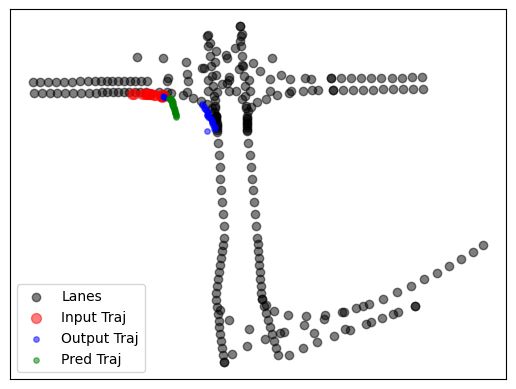

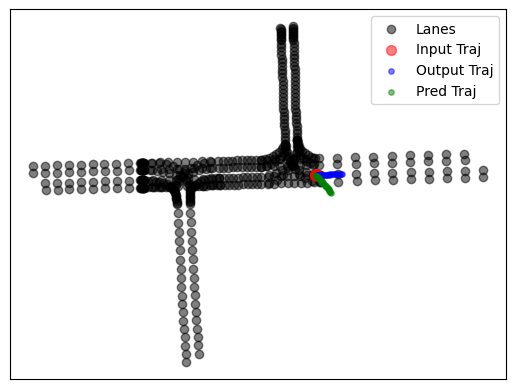

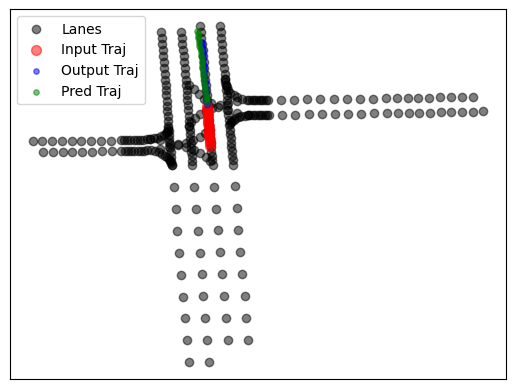

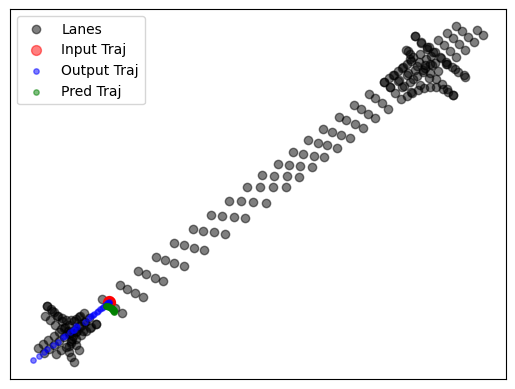

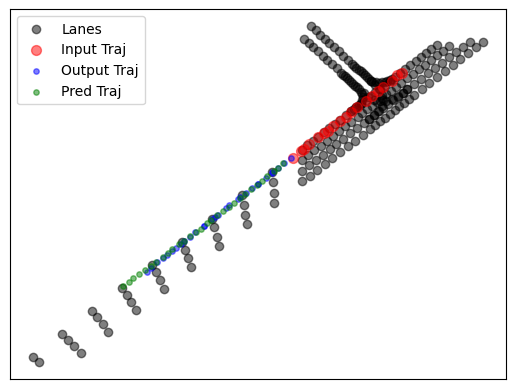

In [49]:
test_path = "./visualize/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        mask = np.where(test_sample['car_mask'] == 1)[0]
        # input: p_in & v_in; output: p_out
        
        p_in_raw = test_sample['p_in']
        p_out_raw = test_sample['p_out'][pred_id]
        v_in_raw = test_sample['v_in']
        lane_scene = test_sample['lane']
        
        # Normalization
        min_vecs = np.min(lane_scene, axis = 0)
        max_vecs = np.max(lane_scene, axis = 0)
        
        # Normalize by vectors
        p_in_norm = (p_in_raw - min_vecs)/(max_vecs - min_vecs)
        
        v_in_norm = np.linalg.norm(v_in_raw, axis=1, keepdims=True)
        v_in_norm = np.where(v_in_norm == 0.0, 1.0, v_in_norm)
        v_in_norm = v_in_raw / v_in_norm
        # v_out_normalized = v_out_raw / np.linalg.norm(v_out_raw, axis=1, keepdims=True)
        p_track = p_in_norm[mask].reshape(-1,19*2)
        v_track = v_in_norm[mask].reshape(-1,19*2)
        
        p_agent = p_in_norm[pred_id].reshape(1,-1)
        v_agent = v_in_norm[pred_id].reshape(1,-1)
        new_mask = []
        p_result = []
        v_result = []
        if (len(mask) > 10):
            
            dist = ((p_track - p_agent)**2).sum(axis=-1)
            #print('dist is ',dist.shape)
            new_mask = np.argpartition(dist,10)[:10]
            
            p_result = p_track[new_mask,:]
            v_result = v_track[new_mask,:]
        else:
            p_result = np.zeros((10,38))
            v_result = np.zeros((10,38))
            k = p_track.shape[0]
            #print('slice',k)
            p_result[:k] = p_track
            v_result[:k] = v_track
        
        #print('shape is',p_agent.shape,v_agent.shape,p_result.shape,v_result.shape)
        inp = np.vstack((p_agent,v_agent,p_result,v_result)).reshape(1,22,38)
        inp = torch.from_numpy(inp).to(device,dtype=torch.float)
        preds,_ = best_model(inp)
        preds = preds.squeeze(0)
        pred = preds[-1, :].cpu().data.numpy()
        pred = rearrange(pred, "(b c) -> b c", c =2 )
        # De-Normalization ! 
        pred = pred * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]

        plt.scatter(lane_scene[:,0], lane_scene[:,1], alpha=0.5, label = "Lanes", color = "black")
        #plt.scatter(train['lane_norm'][:,0], train['lane_norm'][:,1], alpha=0.5, label = "lane_norm", color = "black")

        
        plt.scatter(p_in_raw[pred_id,:,0], p_in_raw[pred_id,:,1], alpha=0.5, label = "Input Traj", color = "red",s=50)
        plt.scatter(p_out_raw[:,0],p_out_raw[:,1], alpha=0.5, label = "Output Traj", color = "blue",s=15)
        plt.scatter(pred[:,0],pred[:,1], alpha=0.5, label = "Pred Traj", color = "green",s=15)
        plt.legend()
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [43]:
print(np.array(test_preds).shape)

(5, 30, 2)


In [ ]:




print(train['p_out'].shape)

# Generate Submission File

In [23]:
# # Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [24]:
# Convert to int
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)